In [49]:
from PIL import Image
import numpy as np
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [50]:
# Set paths
images_folder = '/kaggle/input/ham1000-segmentation-and-classification/images'
masks_folder = '/kaggle/input/ham1000-segmentation-and-classification/masks'
csv_file = '/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv'

# Load the CSV file containing the image and label data
groundtruth_df = pd.read_csv(csv_file)

# Extract image filenames and labels
images = groundtruth_df['image'].values
labels = groundtruth_df.drop(columns=['image']).values  # Drop image_id and keep the one-hot encoded labels

image_paths = []
mask_paths = []
all_labels = []

# Loop over the image filenames and generate paths
for image_filename, label in zip(images, labels):
    # Build image and mask paths
    image_path = os.path.join(images_folder, image_filename) + '.jpg'
    mask_path = os.path.join(masks_folder, image_filename) + '_segmentation.png'
    
    # Append to the lists
    image_paths.append(image_path)
    mask_paths.append(mask_path)
    all_labels.append(list(label))  # Store the one-hot encoded label

# Create a DataFrame with the image paths, mask paths, and labels
data = {
    'image_path': image_paths,
    'mask_path': mask_paths,
    'labels': all_labels
}

data_df = pd.DataFrame(data)

# Display the first few rows of the dataframe

print(data_df.head())


                                          image_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                           mask_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                labels  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
2  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  


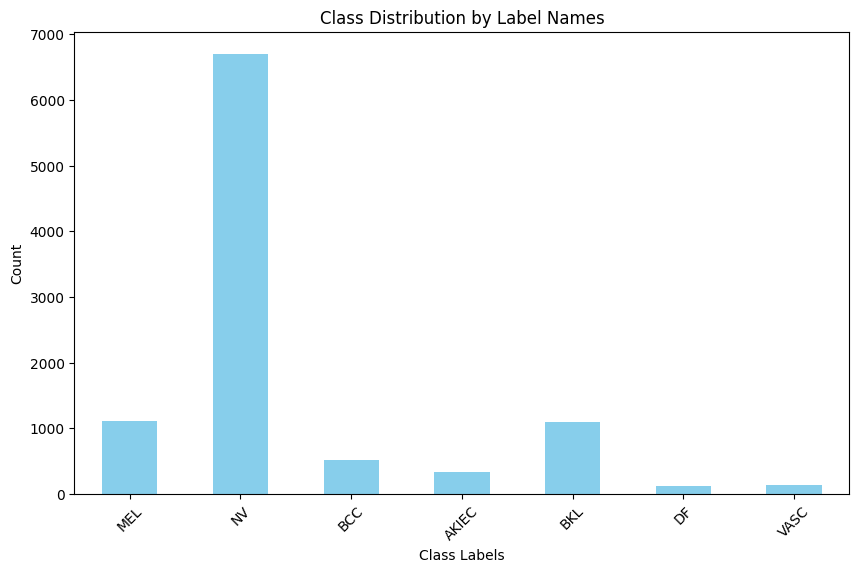

                                          image_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                           mask_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                labels  class_label  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
2  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]            0  
cl

In [51]:
class_labels_map = {
    0: 'MEL',
    1: 'NV',
    2: 'BCC',
    3: 'AKIEC',
    4: 'BKL',
    5: 'DF',
    6: 'VASC'
}

# Convert one-hot encoded labels to class indices
data_df['class_label'] = data_df['labels'].apply(lambda x: x.index(1))  # Convert one-hot to class indices

# Compute class distribution with label names
class_distribution = data_df['class_label'].value_counts().sort_index()
class_distribution.index = class_distribution.index.map(class_labels_map)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution by Label Names')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(data_df.head())
print(data_df['class_label'].value_counts())

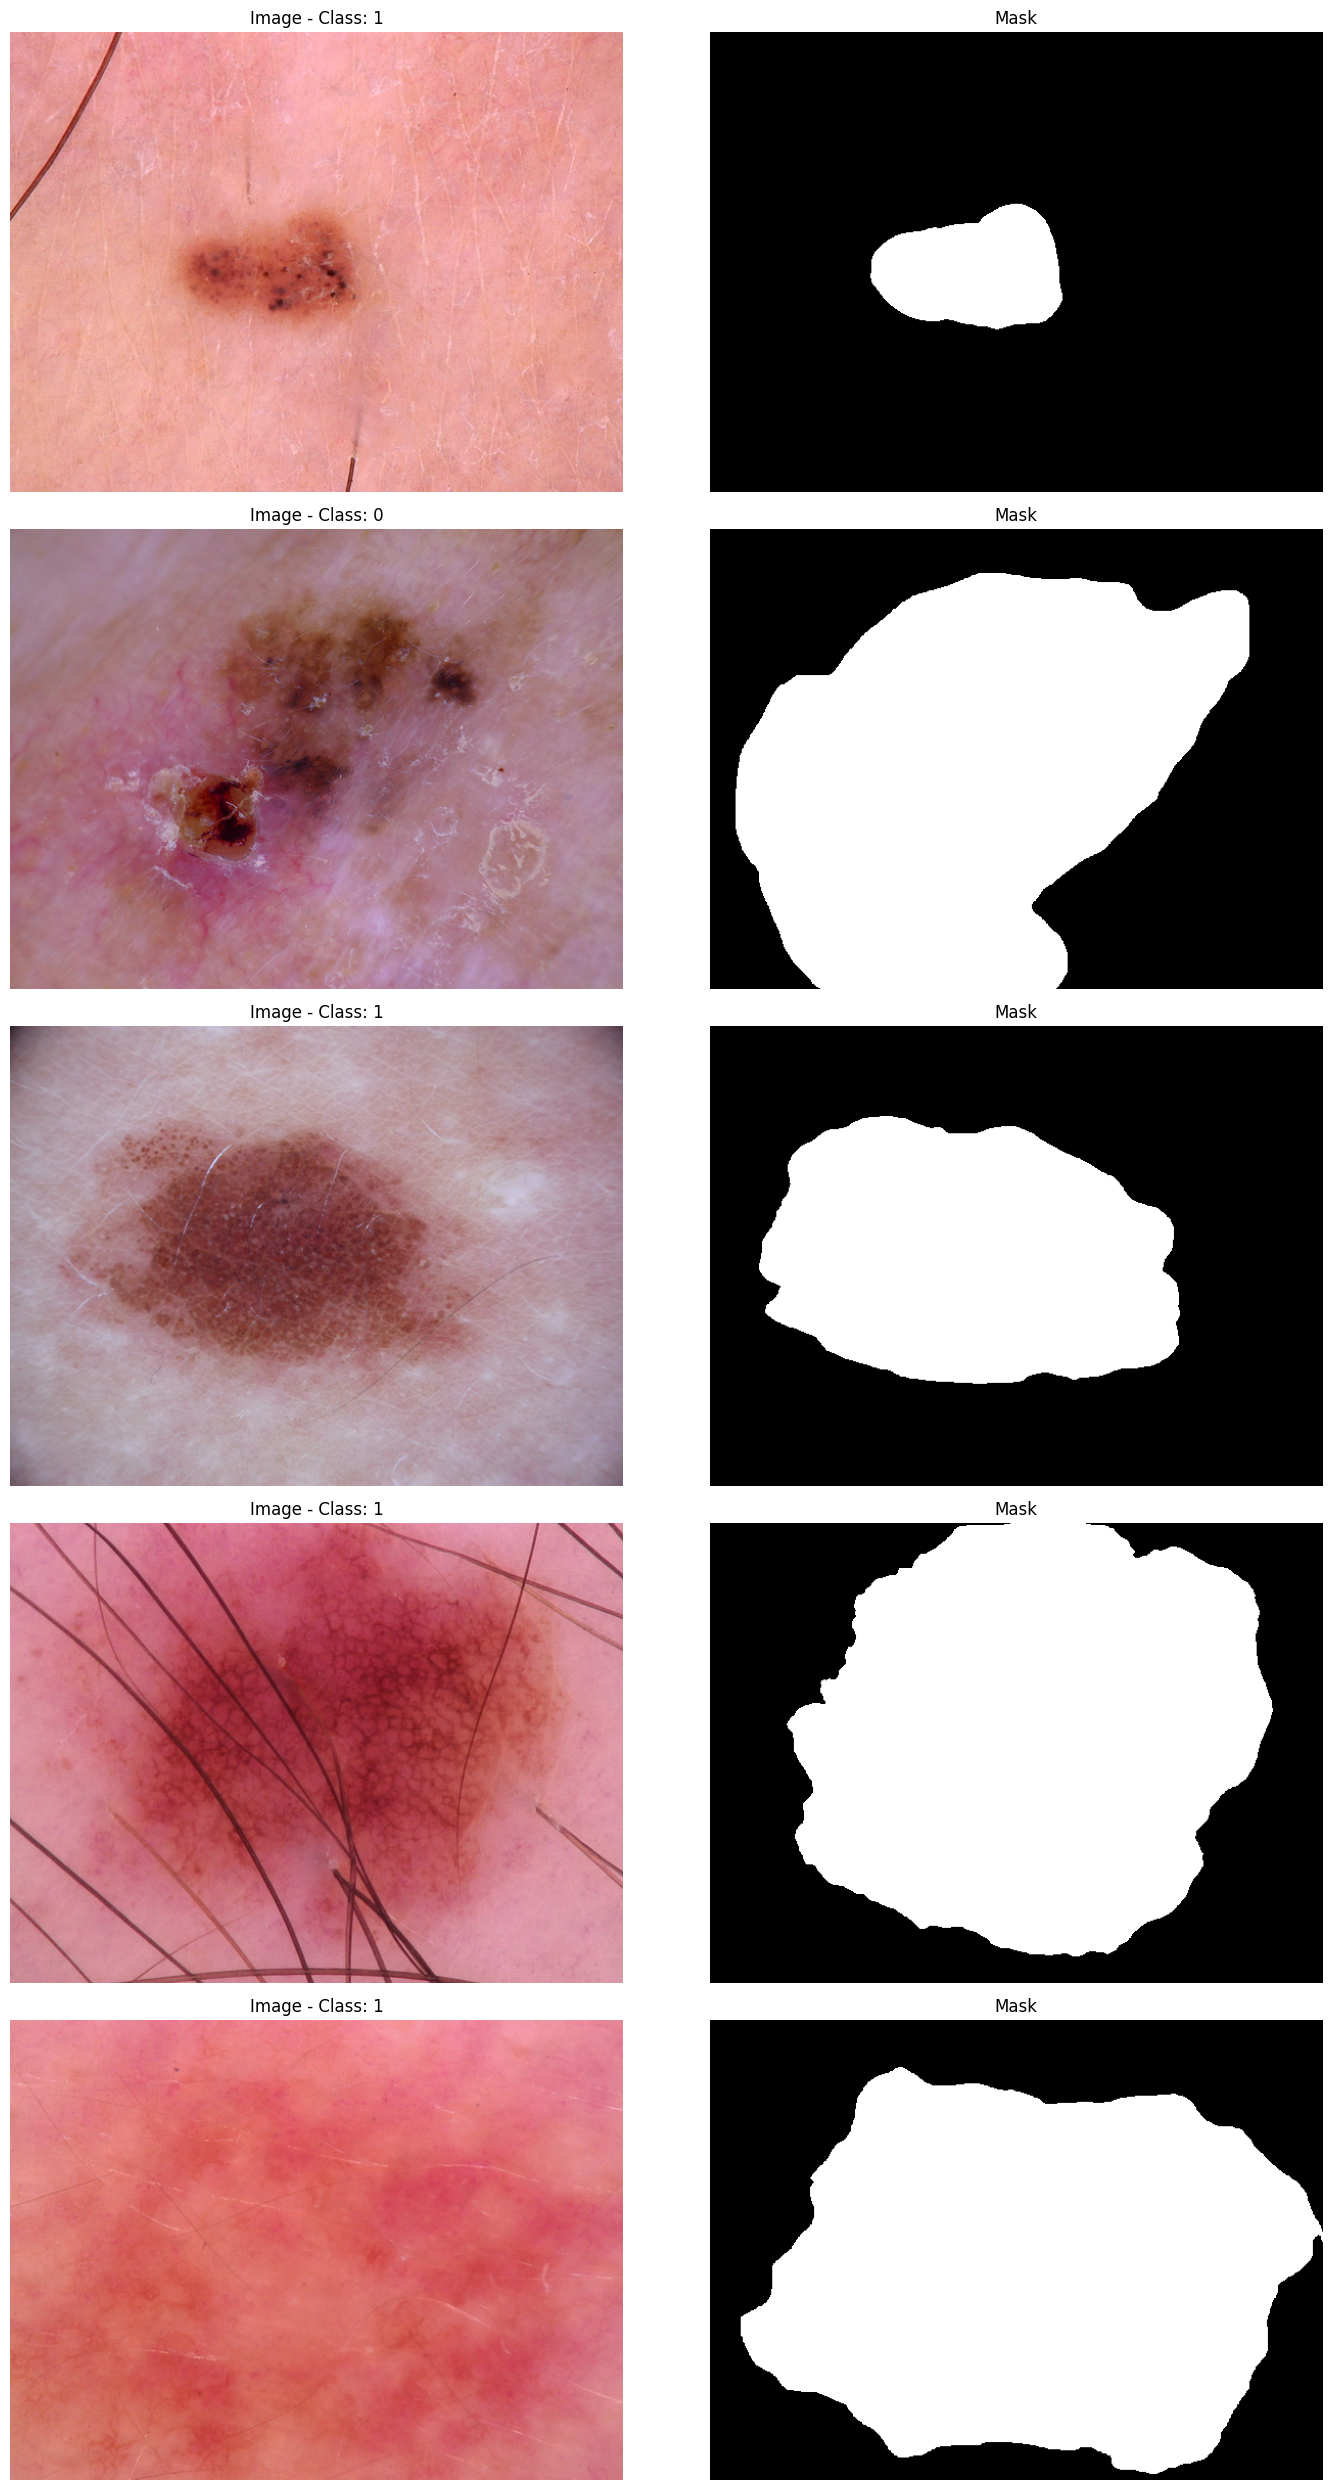

In [52]:
# Display a few samples
def show_samples(dataframe, num_samples=6):
    samples = dataframe.sample(n=num_samples, random_state=None)
    plt.figure(figsize=(15, num_samples * 5))
    
    for i, idx in enumerate(samples.index):
        file_path = dataframe.loc[idx, 'image_path']
        mask_path = dataframe.loc[idx, 'mask_path']
        class_label = dataframe.loc[idx, 'class_label']
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(image)
        plt.title(f"Image - Class: {class_label}")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
show_samples(data_df, num_samples=5)


In [53]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        """
        Initializes the segmentation dataset.

        Args:
            image_paths (list of str): Paths to input images.
            mask_paths (list of str): Paths to corresponding masks.
            labels (list of int or str): Class labels for the masks.
            transform (callable, optional): Transformations to apply to images and masks.
        """
        self.image_paths = image_paths.tolist()
        self.mask_paths = mask_paths.tolist()
        self.labels = labels.tolist()
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Fetches a single sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing:
                - 'image': The transformed input image as a Tensor.
                - 'mask': The transformed mask as a Tensor.
                - 'label': The class label of the sample.
        """
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Ensure image is RGB
        mask = Image.open(self.mask_paths[idx])  # Assume mask is grayscale
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image,label,mask


In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    data_df[['image_path', 'mask_path']],  # Features
    data_df['class_label'],  # Labels
    test_size=0.3,
    stratify=data_df['class_label'],
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_val,  # Features
    y_val,  # Labels
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

print(y_test)
print(y_val)
print(y_train)

4251    1
4592    0
1354    1
8537    4
1505    3
       ..
8371    1
1757    1
668     1
690     1
6045    1
Name: class_label, Length: 1502, dtype: int64
9607    4
9932    1
7818    4
4453    1
5387    1
       ..
6596    1
4608    1
6616    1
6318    1
2363    1
Name: class_label, Length: 1503, dtype: int64
7107    2
3367    0
8698    0
4288    1
6172    1
       ..
6815    1
3534    1
5803    1
1014    1
4986    1
Name: class_label, Length: 7010, dtype: int64


In [55]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [56]:
# Dataset and DataLoader
train_dataset = SegmentationDataset(X_train['image_path'],X_train['mask_path'].values, y_train, transform=train_transform)
val_dataset = SegmentationDataset(X_val['image_path'],X_val['mask_path'].values, y_val, transform=test_transform)
test_dataset = SegmentationDataset(X_test['image_path'], X_test['mask_path'].values, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


****CNN****

In [57]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)  # Use ResNet18 as a base model
        
        # Enable fine-tuning: Allow gradients for all layers
        for param in self.model.parameters():
            param.requires_grad = True

        # Modify the fully connected layer with dropout
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Drop 50% of neurons
            nn.Linear(self.model.fc.in_features, num_classes)  # Final classification layer
        )

    def forward(self, x):
        return self.model(x)

# Create model
model = SimpleCNN(num_classes=len(class_labels_map))
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has 11,180,103 parameters


Epoch 1/10, Loss: 0.7942, Train Accuracy: 0.7185, Val Accuracy: 0.7891, Val Loss: 0.5859
Epoch 2/10, Loss: 0.5315, Train Accuracy: 0.8123, Val Accuracy: 0.8170, Val Loss: 0.5143
Epoch 3/10, Loss: 0.4369, Train Accuracy: 0.8471, Val Accuracy: 0.8263, Val Loss: 0.4939
Epoch 4/10, Loss: 0.3677, Train Accuracy: 0.8639, Val Accuracy: 0.8117, Val Loss: 0.5086
Epoch 5/10, Loss: 0.3374, Train Accuracy: 0.8716, Val Accuracy: 0.8383, Val Loss: 0.4906
Epoch 6/10, Loss: 0.2665, Train Accuracy: 0.9017, Val Accuracy: 0.8430, Val Loss: 0.4268
Epoch 7/10, Loss: 0.2327, Train Accuracy: 0.9168, Val Accuracy: 0.8490, Val Loss: 0.4357
Epoch 8/10, Loss: 0.2017, Train Accuracy: 0.9284, Val Accuracy: 0.8503, Val Loss: 0.4816
Epoch 9/10, Loss: 0.1712, Train Accuracy: 0.9399, Val Accuracy: 0.8583, Val Loss: 0.4408
Epoch 10/10, Loss: 0.1443, Train Accuracy: 0.9486, Val Accuracy: 0.8230, Val Loss: 0.5317
Best Validation Accuracy: 0.8583


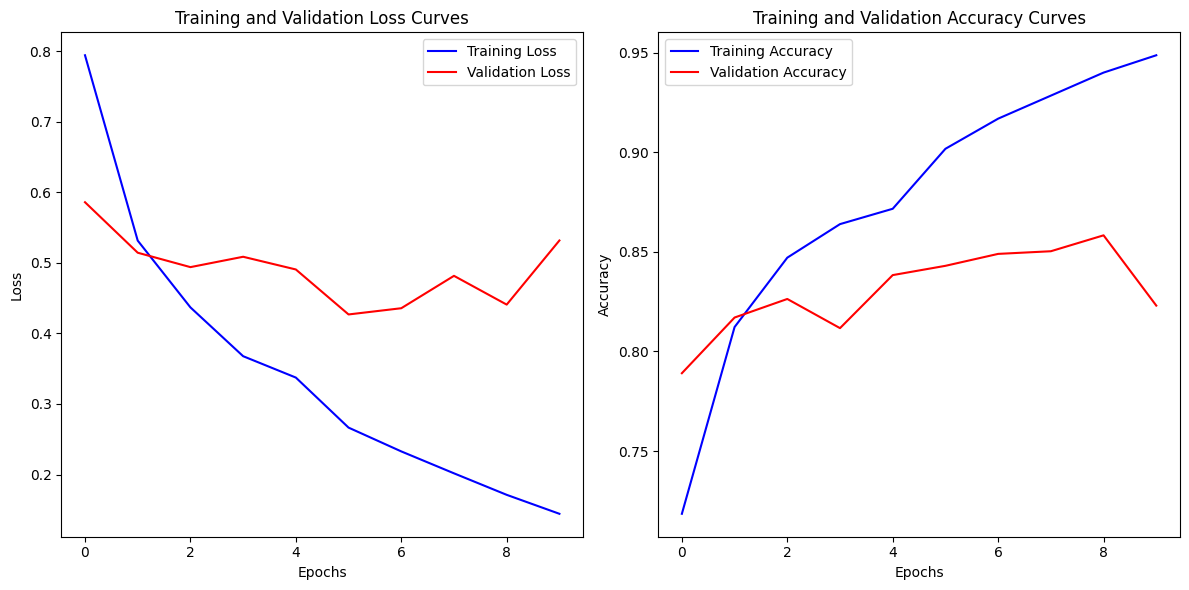

In [58]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    val_losses = []  # To track validation losses
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training phase
        for images, labels,masks in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train  # Training accuracy

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0  # To accumulate validation loss
        
        with torch.no_grad():
            for images, labels,masks in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Validation loss
                val_loss += loss.item() * images.size(0)
                
                # Compute validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val  # Validation accuracy

        # Store values for plotting
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)  # Store validation loss
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print training and validation accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
        
        best_acc = max(best_acc, val_acc)
    
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    # Plotting the Loss and Accuracy Curves
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()

    # Plot Training and Validation Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, num_epochs=10)

Test Accuracy: 0.8342
[0.53278689 0.93847758 0.94       0.5483871  0.75       0.75
 0.82608696] [0.77844311 0.89463221 0.61038961 0.69387755 0.69090909 0.52941176
 0.9047619 ] [0.63260341 0.91603053 0.74015748 0.61261261 0.7192429  0.62068966
 0.86363636]

Per-Class Precision, Recall, and F1 Score:
Class 0: Precision = 0.5328, Recall = 0.7784, F1 = 0.6326
Class 1: Precision = 0.9385, Recall = 0.8946, F1 = 0.9160
Class 2: Precision = 0.9400, Recall = 0.6104, F1 = 0.7402
Class 3: Precision = 0.5484, Recall = 0.6939, F1 = 0.6126
Class 4: Precision = 0.7500, Recall = 0.6909, F1 = 0.7192
Class 5: Precision = 0.7500, Recall = 0.5294, F1 = 0.6207
Class 6: Precision = 0.8261, Recall = 0.9048, F1 = 0.8636


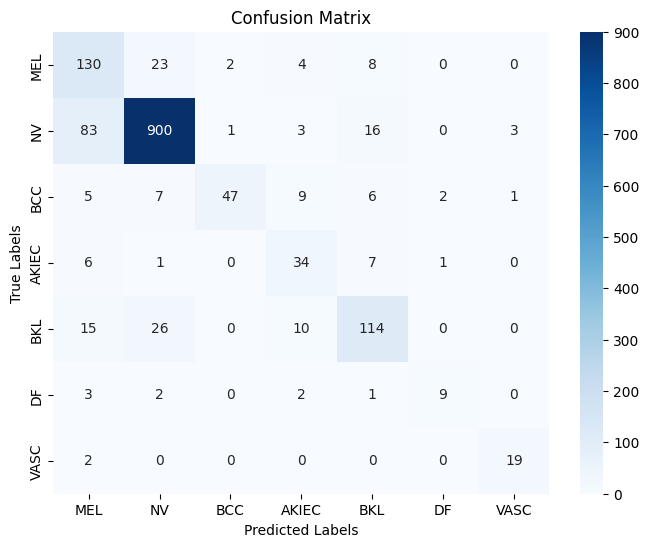

In [59]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torchvision.transforms as transforms
# Define the test model
def test_model(model, test_loader, class_labels_map):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        # Loop through the test set
        for images, labels,masks in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Track predictions and actual labels
            predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
            actuals.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
            
            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Compute the confusion matrix
    cm = confusion_matrix(actuals, predictions)

    # Calculate precision, recall, and F1 score per class
    precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average=None)

    print(precision, recall, f1)
    # Print per-class precision, recall, and F1 score
    print("\nPer-Class Precision, Recall, and F1 Score:")
    for i in range(len(precision)):
        print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1 = {f1[i]:.4f}")

    # Plot the confusion matrix
    plot_confusion_matrix(cm, class_labels_map)

    return predictions, actuals


def plot_confusion_matrix(cm, class_labels_map):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels_map.values(), yticklabels=class_labels_map.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# Get predictions and actual labels
predictions, actuals = test_model(model, test_loader, class_labels_map)

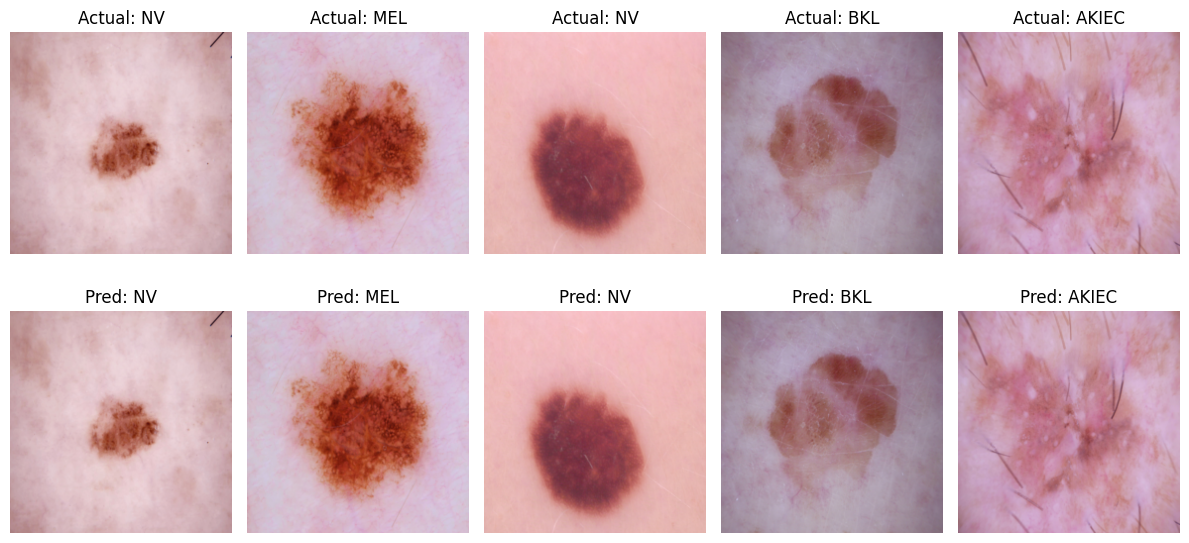

In [60]:
def display_sample_images(test_loader, predictions, actuals, class_labels_map, num_images=5):
    # Get a batch of test images
    images, labels ,masks = next(iter(test_loader))
    
    # Convert images to numpy arrays for displaying
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert to HWC format
    
    # Plot random images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        img = images[i]
        plt.imshow(np.clip(img, 0, 1))  # Ensure values are between 0 and 1 for display
        plt.title(f"Actual: {class_labels_map[actuals[i]]}")
        plt.axis('off')
        
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Pred: {class_labels_map[predictions[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images along with actual and predicted labels
display_sample_images(test_loader, predictions, actuals, class_labels_map)

**SEGMENTATION**

In [61]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.softmax(inputs, dim=1)  # Apply softmax for class probabilities
        targets = torch.nn.functional.one_hot(targets, num_classes=inputs.shape[1])  # One-hot encoding
        targets = targets.permute(0, 3, 1, 2).float()  # Change shape to match inputs
        intersection = (inputs * targets).sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + smooth)
        return 1 - dice.mean()

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        # Encoder: ResNet-34 without fully connected layers
        self.encoder = models.resnet34(pretrained=True)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC layers

        # Decoder: Use multiple ConvTranspose2d layers for upsampling
        self.decoder1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        # Final convolution for classification
        self.classifier = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder (ResNet-34)
        enc = self.encoder(x)

        # Decoder: Upsampling through ConvTranspose2d layers
        dec1 = self.decoder1(enc)
        dec2 = self.decoder2(dec1)
        dec3 = self.decoder3(dec2)
        dec4 = self.decoder4(dec3)
        dec5 = self.decoder5(dec4)
        
        # Final classification
        output = self.classifier(dec5)
        return output

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=7).to(device)

# Freezing initial layers of encoder for first 5 epochs
def freeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = False

def unfreeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = True

# Combined Loss Function
def combined_loss(outputs, targets):
    ce_loss = nn.CrossEntropyLoss()(outputs, targets)
    dice_loss = DiceLoss()(outputs, targets)
    return ce_loss + dice_loss

criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_23/3501388718.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [62]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    best_acc = 0.0
    freeze_encoder(model)  # Freeze encoder initially

    for epoch in range(num_epochs):
        if epoch == 5:  # Unfreeze encoder after 5 epochs
            unfreeze_encoder(model)

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for images, _, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks.long())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += masks.numel()
            correct_train += (predicted == masks).sum().item()

        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, _, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = masks.squeeze(1)

                outputs = model(images)
                loss = criterion(outputs, masks.long())
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                total_val += masks.numel()
                correct_val += (predicted == masks).sum().item()

        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader.dataset):.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss/len(val_loader.dataset):.4f}, "
              f"Val Accuracy: {val_acc:.4f}")

        best_acc = max(best_acc, val_acc)

    print(f"Best Validation Accuracy: {best_acc:.4f}")

# Example usage
# Assuming train_loader and val_loader are defined
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)


/tmp/ipykernel_23/1840118555.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Train Loss: 1.4982, Train Accuracy: 0.6395, Val Loss: 0.8055, Val Accuracy: 0.7149
Epoch 2/10, Train Loss: 0.7194, Train Accuracy: 0.7092, Val Loss: 0.7211, Val Accuracy: 0.7150
Epoch 3/10, Train Loss: 0.6145, Train Accuracy: 0.7543, Val Loss: 0.5276, Val Accuracy: 0.8126
Epoch 4/10, Train Loss: 0.5266, Train Accuracy: 0.8099, Val Loss: 0.4964, Val Accuracy: 0.8211
Epoch 5/10, Train Loss: 0.5055, Train Accuracy: 0.8191, Val Loss: 0.4806, Val Accuracy: 0.8305
Epoch 6/10, Train Loss: 0.4106, Train Accuracy: 0.8601, Val Loss: 0.3352, Val Accuracy: 0.8937
Epoch 7/10, Train Loss: 0.3707, Train Accuracy: 0.8731, Val Loss: 0.3304, Val Accuracy: 0.8939
Epoch 8/10, Train Loss: 0.3571, Train Accuracy: 0.8775, Val Loss: 0.3215, Val Accuracy: 0.8965
Epoch 9/10, Train Loss: 0.3483, Train Accuracy: 0.8793, Val Loss: 0.3310, Val Accuracy: 0.8929
Epoch 10/10, Train Loss: 0.3434, Train Accuracy: 0.8814, Val Loss: 0.3335, Val Accuracy: 0.8973
Best Validation Accuracy: 0.8973


In [63]:
# testing

model.eval()
val_loss = 0
with torch.no_grad():
    for images,label,masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)
        outputs = model(images)
        val_loss += criterion(outputs, masks.long()).item()

print(f"test Loss: {val_loss / len(test_loader)}")

test Loss: 0.3594442945211492


In [64]:
def calculate_iou(preds, labels):
    intersection = (preds & labels).sum((1, 2))
    union = (preds | labels).sum((1, 2))
    return (intersection / union).mean()

def dice_coefficient(preds, labels):
    intersection = (preds * labels).sum((1, 2))
    return (2. * intersection / (preds.sum((1, 2)) + labels.sum((1, 2)))).mean()

In [65]:
# Testing using IoU and Dice Coefficient

model.eval()
test_iou, test_dice = 0, 0
with torch.no_grad():
    for images,label,masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        test_iou += calculate_iou(preds, masks.long())
        test_dice += dice_coefficient(preds, masks.long())

print(f"Test IoU: {test_iou / len(test_loader)}, Dice: {test_dice / len(test_loader)}")

Test IoU: 0.7100927233695984, Dice: 0.8101553916931152


****BONUS****

In [66]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import torch.optim as optim

# Enable CUDA Launch Blocking for better error debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

class MultiTaskModel(nn.Module):
    def __init__(self, num_classes, num_segmentation_classes):
        super(MultiTaskModel, self).__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove FC layers
        
        # Fine-tune: Freeze early layers
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze the last layers of ResNet34
        for param in self.backbone[-2:].parameters():
            param.requires_grad = True
        
        # Classification head with Dropout
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(512, num_classes),
            nn.Dropout(0.5)  # Dropout layer
        )
        
        # Segmentation head with Dropout
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_segmentation_classes, kernel_size=1),
            nn.Dropout(0.5)  # Dropout layer
        )
        
        # Upsample the segmentation logits to match input image size (224x224)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
    
    def forward(self, x):
        features = self.backbone(x)
        
        # Classification
        class_logits = self.classification_head(features)
        
        # Segmentation (before upsampling)
        segmentation_logits = self.segmentation_head(features)
        
        # Upsample segmentation logits to match image size
        segmentation_logits = self.upsample(segmentation_logits)
        
        return class_logits, segmentation_logits

# Initialize model
num_classes = 7  # For classification (e.g., 3 categories)
num_segmentation_classes = 7  # For segmentation (e.g., 4 labels including background)
model = MultiTaskModel(num_classes, num_segmentation_classes)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)  # Move model to device

# Example inputs
batch_size = 8
image_tensor = torch.randn(batch_size, 3, 224, 224).to(device).float()  # Random images on device
classification_labels = torch.randint(0, num_classes-1, (batch_size,)).to(device).long()  # Random class labels on device
segmentation_masks = torch.randint(0, num_segmentation_classes-1, (batch_size, 224, 224)).to(device).long()  # Random masks on device

# Debugging: Print min and max values of labels and masks
print("Classification Labels Min/Max:", classification_labels.min(), classification_labels.max())
print("Segmentation Masks Min/Max:", segmentation_masks.min(), segmentation_masks.max())

# Pass data through the model
class_logits, segmentation_logits = model(image_tensor)

# Debugging: Print the shapes of the outputs
print("Class Logits Shape:", class_logits.shape)  # [8, num_classes]
print("Segmentation Logits Shape:", segmentation_logits.shape)  # [8, num_segmentation_classes, 224, 224]

# Define loss functions
classification_loss_fn = nn.CrossEntropyLoss()
segmentation_loss_fn = nn.CrossEntropyLoss()

# Compute losses
classification_loss = classification_loss_fn(class_logits, classification_labels)
segmentation_loss = segmentation_loss_fn(segmentation_logits, segmentation_masks)
total_loss = classification_loss + segmentation_loss

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels, masks in train_loader:  # Assume train_loader is defined
        # Move data to GPU if available
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        masks = masks.squeeze(1)
        
        # Forward pass
        class_logits, segmentation_logits = model(images)
        
        # Compute losses
        classification_loss = classification_loss_fn(class_logits, labels)
        segmentation_loss = segmentation_loss_fn(segmentation_logits, masks.long())
        total_loss = 0.8 * classification_loss + 1.2 * segmentation_loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        running_loss += total_loss.item()
        
        # Compute accuracy for classification
        _, predicted = torch.max(class_logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Model Evaluation using val_loader
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels, masks in val_loader:  # Assume val_loader is defined
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            masks = masks.squeeze(1)
            class_logits, segmentation_logits = model(images)
            
            # Compute losses
            class_loss = classification_loss_fn(class_logits, labels)
            seg_loss = segmentation_loss_fn(segmentation_logits, masks.long())
            val_loss += class_loss.item() + seg_loss.item()
            
            # Compute accuracy (for classification)
            _, predicted = torch.max(class_logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for training and validation
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Classification Labels Min/Max: tensor(0, device='cuda:0') tensor(4, device='cuda:0')
Segmentation Masks Min/Max: tensor(0, device='cuda:0') tensor(5, device='cuda:0')
Class Logits Shape: torch.Size([8, 7])
Segmentation Logits Shape: torch.Size([8, 7, 224, 224])
Epoch 1/10, Train Loss: 1.7869, Train Accuracy: 52.82%, Val Loss: 0.9638, Val Accuracy: 77.31%
Epoch 2/10, Train Loss: 1.5358, Train Accuracy: 59.80%, Val Loss: 0.9205, Val Accuracy: 79.37%
Epoch 3/10, Train Loss: 1.4687, Train Accuracy: 61.13%, Val Loss: 0.8363, Val Accuracy: 80.51%
Epoch 4/10, Train Loss: 1.4309, Train Accuracy: 62.10%, Val Loss: 0.7990, Val Accuracy: 81.90%
Epoch 5/10, Train Loss: 1.3973, Train Accuracy: 62.70%, Val Loss: 0.7976, Val Accuracy: 82.97%
Epoch 6/10, Train Loss: 1.3707, Train Accuracy: 63.72%, Val Loss: 0.8041, Val Accuracy: 81.70%
Epoch 7/10, Train Loss: 1.3192, Train Accuracy: 65.32%, Val Loss: 0.7652, Val Accuracy: 84.10%
Epoch 8/10, Train Loss: 1.2967, Train Accuracy: 66.70%

In [67]:
# Set the model to evaluation mode
model.eval()

# Define variables to track loss and metrics
total_classification_loss = 0
total_segmentation_loss = 0
total_batches = 0
correct_predictions = 0
total_samples = 0
iou_sum = 0
dice_sum = 0

# No gradient computation for evaluation
with torch.no_grad():
    for images, labels, masks in test_loader:  # Assume test_loader is defined
        # Move data to device
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        masks = masks.squeeze(1)  # Ensure masks have the correct shape

        # Forward pass
        class_logits, segmentation_logits = model(images)

        # Compute classification loss
        classification_loss = classification_loss_fn(class_logits, labels)
        total_classification_loss += classification_loss.item()

        # Compute segmentation loss
        segmentation_loss = segmentation_loss_fn(segmentation_logits, masks.long())
        total_segmentation_loss += segmentation_loss.item()

        # Update metrics
        total_batches += 1
        correct_predictions += (torch.argmax(class_logits, dim=1) == labels).sum().item()
        total_samples += labels.size(0)

        # Calculate IoU and Dice for each image in the batch
        predicted_masks = torch.argmax(segmentation_logits, dim=1)  # Predicted masks
        for pred, target in zip(predicted_masks.long(), masks.long()):
            # Flatten tensors to calculate metrics
            pred = pred.view(-1)
            target = target.view(-1)

            intersection = (pred & target).float().sum().item()
            union = (pred | target).float().sum().item()
            iou = intersection / union if union > 0 else 0  # Handle division by zero
            dice = (2 * intersection) / (pred.sum().item() + target.sum().item()) if pred.sum().item() + target.sum().item() > 0 else 0

            iou_sum += iou
            dice_sum += dice

# Average the losses and metrics over all batches
avg_classification_loss = total_classification_loss / total_batches
avg_segmentation_loss = total_segmentation_loss / total_batches
accuracy = correct_predictions / total_samples
avg_iou = iou_sum / total_samples
avg_dice = dice_sum / total_samples

# Print test results
print(f"Test Classification Loss: {avg_classification_loss:.4f}")
print(f"Test Segmentation Loss: {avg_segmentation_loss:.4f}")
print(f"Total Test Loss: {avg_classification_loss + avg_segmentation_loss:.4f}")
print(f"Classification Accuracy: {accuracy:.2%}")
print(f"Segmentation IoU: {avg_iou:.4f}")
print(f"Segmentation Dice Score: {avg_dice:.4f}")


Test Classification Loss: 0.4641
Test Segmentation Loss: 0.3234
Total Test Loss: 0.7875
Classification Accuracy: 85.82%
Segmentation IoU: 0.6560
Segmentation Dice Score: 0.7665
